## Introduction to CNNs with Keras and Tensorflow

This is a tutorial from https://medium.com/@aggirma/part-1-convolutional-neural-network-in-a-nutshell-89f81a329ec3, an introduction to CNNs, first doing theory and then implementation in keras with tensorflow.
The used dataset are hand-gestures, and we will classify how many fingers are shown.
He references to here https://timdettmers.com/2015/03/26/convolution-deep-learning/, which is a great in-depth explanation of convolutional learning.

In [1]:
#Import libraries
import tensorflow as tf
import numpy as np
import os

#Keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

#Required for preventing ipy kernel crash
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [2]:
#Set batch size: How many images the model processes, before it updates weights and biases.
nbatch = 32

#ImageDataGenerator: augument data by shifting, zooming, rotating, mirroring. This increases training data and
#assures data are not biased to particular handedness

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 12.,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.15,
                                   horizontal_flip = True
                                  )

test_datagen = ImageDataGenerator(rescale = 1./255)


#Loading our images from the respective folders
train_gen = train_datagen.flow_from_directory(
        'images/train/',
        target_size = (256,256),
        color_mode = 'grayscale',
        batch_size = nbatch,
        classes = ["NONE", "ONE", "TWO", "THREE", "FOUR", "FIVE"],
        class_mode = 'categorical'
        )

test_gen = test_datagen.flow_from_directory(
        'images/test/',
        target_size = (256,256),
        color_mode = 'grayscale',
        batch_size = nbatch,
        classes = ["NONE", "ONE", "TWO", "THREE", "FOUR", "FIVE"],
        class_mode = 'categorical'
        )


Found 9081 images belonging to 6 classes.
Found 3632 images belonging to 6 classes.


(32, 256, 256, 1) (32, 6)


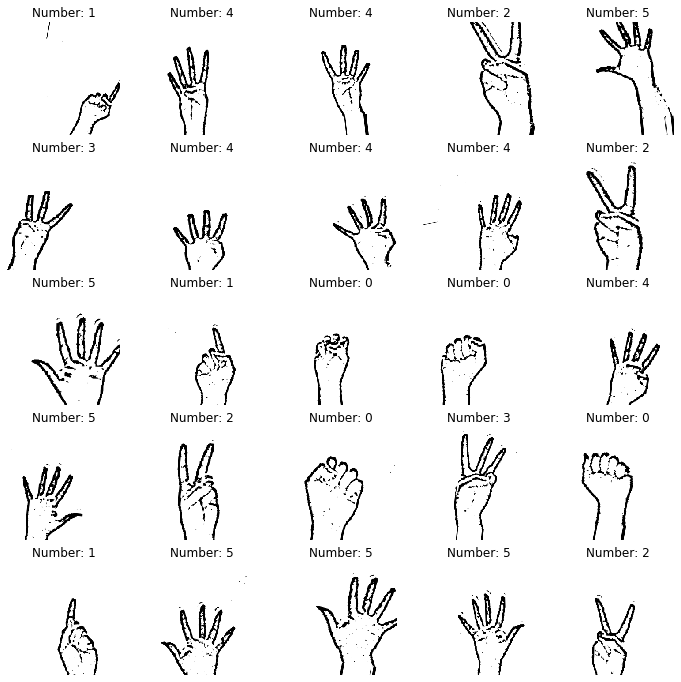

In [3]:
# Let's display some images, shall we?
for x, y in train_gen:
    print(x.shape, y.shape)
    
    plt.figure(figsize = (12,12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.axis('off')
        plt.title('Number: %d' % np.argmax(y[i]))
        img = np.uint8(255*x[i, :, :, 0])
        plt.imshow(img, cmap = 'gray')
    break

In [4]:
#CNN Model Building#
model = Sequential()
model.add(Conv2D(32, (3,3), activation = 'relu',
                 input_shape = (256, 256, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(Conv2D(64, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(256, (3,3), activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(150, activation = 'relu'))
model.add(Dropout(0.25))
model.add(Dense(6, activation = 'softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 123, 123, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 29, 29, 128)      

In [5]:
#Compile the model. Adam is the inital optimization algorithm,
#GD is used most and other algorithms can be used too, of course:
#Adagrad, AdaDelta, Gradient Descent, ...
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [6]:
#Following command is used to monitor validation loss
#and to save the model
callbacks_list = [
    EarlyStopping(monitor = 'val_loss', patience = 10),
    ModelCheckpoint(filepath = 'cnn_model_6cat.h6',
                    monitor = 'val_loss', save_best_only = True)
]

In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [9]:
#Model needs to be trained with CPU, because GPU does not work for tf
# os.environ['CUDA_VISIBLE_DEVICES'] = '0'
with tf.device('/CPU:0'):
    history = model.fit_generator(
        train_gen,
        steps_per_epoch = 32,
        epochs = 1,
        validation_data = test_gen,
        validation_steps = 28,
        callbacks = callbacks_list
    )

Epoch 1/1
32/32 [==============================] - 94s 3s/step - loss: 1.8435 - acc: 0.1740 - val_loss: 1.7881 - val_acc: 0.1652


In [13]:
# Model can be evaluated now
test_loss, test_ac = model.evaluate_generator(test_gen, verbose=2)

In [14]:
test_ac

0.1668502241373062